# SentinelPy package notes

The purpose of this package is to:
- allow direct numpy interfacing with the sentinel 1 and sentinel 2 dataset
- allow quick identification of geographic regions specified by .shp and .geojson files specifying geographic extents

## 1.1 General Principles

'Image' (e.g. sentinelTwoImage) refers to a 2D pixel array stored in a file. The sentinelImage classes should all have a .data attribute which behaves like an array. Multiple image instances may refer to the same file, but should be used to address different 2D arrays within a file. This is not an explicit requirement of the image instances however. For MSI files from within a sentinel 2 package, each instance might be a different spectral band. For sentinel 1, an image may be a 2D array of values representing a radar polarisation state. The important assumption is that the data should be 2D and projected into a meaningful spatial domain (WGS 84 UTM Grid projection). In the specific context of the sentinelpy package, any image class should also contain explicit georeferencing information (normally top left pixel coordinates and pixel size). 

'Granule' (i.e. sentinelTwoGranule) refers to an image or collection of images with the same spatial domains (i.e multiple sentinelTwoImages, with each sentinelImage representing a different waveband's reflectance for the same defined spatial region). Granules should not permit partially overlapping/ non-overlapping images to be stored in the same instance of a granule. Different resolution images may be stored in the same instance of a granule, however the transformation between spatial resolutions should be defined within the granule. Granules should contain the capture date and the all the georeferencing  information (this means images might not need georeferencing information to be contained)

'Region Of Interest' or 'ROI' is defined as a spatial region which may be defined by a series of points forming a boundary. Therefore the pixels of an image may be contained within a ROI, however a ROI does not need to explicitly be contained by any particular pixel array.

The batchProcessor class should be used to do any vector-to-pixel or pixel-to-pixel operation (for example, postage stamp extraction). This class accepts a single granule object and a list of ROI objects. The purpose of the class is to minimise file open operations which can significantly slow down the workflow.

## 1.2 Object naming

classes should use the format: thisIsAClassName

class variables should use the format: classVariable

user callable methods should use the format: this_is_a_public_method

private methods should uset the format: _this_is_a_private_method

# Demonstration

## 2.1 Basic I/O

Sentinel 2 Granules are read in using the sentinelTwoGranule class. As the older format had multiple granules in the master directory, it is necessary to explicitly identify the desired granule with the 'mgrsGridSquare' variable as follows:

In [1]:
import sentinelPy as sp

# import a test granule

gran = sp.sentinelTwoGranule(
    mgrsGridSquare='30UXC',
    # replace the below with any valid 30UXC SAFE file
    safeFolderPath='S2A_USER_PRD_MSIL2A_PDMC_20160815T205347_R137_V20160815T110652_20160815T110803.SAFE'
)

### 2.1.1 sentinelGranule attributes

Granule capture date:

In [2]:
print(gran.captureDate)

2016-08-15


check the process level:

In [3]:
gran.processLevel

'Level-2Ap'

or generate a quick ipython preview:

In [4]:
gran.imshow()

The image granules are stored in the msiBands dictionary and are named as in the original image files (https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial)

In [5]:
gran.msiBands['B01']


Multi-Spectral Image Slice
---------------------------
File location: /Users/joefennell/Documents/AgriSat/sentinelPy_public/sentinelpy/S2A_USER_PRD_MSIL2A_PDMC_20160815T205347_R137_V20160815T110652_20160815T110803.SAFE/GRANULE/S2A_USER_MSI_L2A_TL_SGS__20160815T162841_A005997_T30UXC_N02.04/IMG_DATA/R60m/S2A_USER_MSI_L2A_TL_SGS__20160815T162841_A005997_T30UXC_B01_60m.jp2

Pixel Resolution: 60m
Band Name: B01
Date: 2016-08-15

There's also a scene classification layer stored in:

In [6]:
gran.SCL


Scene Classification Layer
---------------------------
File location: /Users/joefennell/Documents/AgriSat/sentinelPy_public/sentinelpy/S2A_USER_PRD_MSIL2A_PDMC_20160815T205347_R137_V20160815T110652_20160815T110803.SAFE/GRANULE/S2A_USER_MSI_L2A_TL_SGS__20160815T162841_A005997_T30UXC_N02.04/IMG_DATA/S2A_USER_SCL_L2A_TL_SGS__20160815T162841_A005997_T30UXC_20m.jp2

Pixel Resolution: 20m
Band Name: Scene Classification Layer
Date: 2016-08-15

### 2.1.2 sentinelImage Attributes

sentinelImage objects have the following user attributes:

In [7]:
blue = gran.msiBands['B02']

In [8]:
blue.bandName

'B02'

In [9]:
print('UTM hemisphere: '+blue.refPixUtmHemisphere)
print('UTM longitude zone: '+str(blue.refPixUtmZone))
print('UTM x and y coordinates for bounding box:')
blue.bboxUtm

UTM hemisphere: N
UTM longitude zone: 30
UTM x and y coordinates for bounding box:


((600005, 5800015),
 (700005, 5800015),
 (700005, 5700015),
 (600005, 5700015),
 (600005, 5800015))

UTM pixel coordinates for top left pixel:

In [10]:
blue.refPixUtm

(600005, 5800015)

Pixel size (x and y) in metres:

In [11]:
blue.pixelSize

10

The scene classification layer has additional attributes:

In [12]:
classification_layer = gran.SCL

In [13]:
classification_layer.layerNames

{0: 'NODATA',
 1: 'SATURATED_DEFECTIVE',
 2: 'DARK_FEATURE_SHADOW',
 3: 'CLOUD_SHADOW',
 4: 'VEGETATION',
 5: 'BARE_SOIL_DESERT',
 6: 'WATER',
 7: 'CLOUD_LOW_PROBA',
 8: 'CLOUD_MEDIUM_PROBA',
 9: 'CLOUD_HIGH_PROBA',
 10: 'THIN_CIRRUS',
 11: 'SNOW_ICE'}

### 2.1.3 sentinelROI attributes

In [14]:
farm = sp.sentinelROI('farm.geojson')

From this class, we can access various coordinates (needs a tidy up):

In [15]:
# bounding box in UTM (WG84) coordinates
farm.bboxUtm

((604835.0, 5783853.0),
 (606338.0, 5783853.0),
 (606338.0, 5781515.0),
 (604835.0, 5781515.0),
 (604835.0, 5783853.0))

## 2.2 ROI cutout

In [16]:
# List of ROIs
ROI_list = [
    sp.sentinelROI('farm.geojson'),
    sp.sentinelROI('field.geojson'),
    sp.sentinelROI('housing.geojson')
]

Quick description of how to extract a region-of-interest as a pixel array.

An instance of the class is first defined:

In [17]:
farmProcessor = sp.batchProcessor(gran,ROI_list)

Note: the default is to do the read operations automatically. To prevent  this, use readFiles=False.

To return the np arrays, call the as_NP_arrays method:

In [18]:
small_arrays = farmProcessor.as_NP_arrays()

This gives an m x n x waveband numpy array:

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))

for i,im in enumerate(small_arrays):
    fig.add_subplot(1,3,i+1)
    plt.imshow(im[:,:,1],cmap='RdYlGn')
    plt.title('Green Channel Surface Reflectance')
plt.colorbar()
plt.show()

The pixel coordinates of the bounding box can be extracted (in format (ymin,ymax,xmin,xmax) ):

In [20]:
farmProcessor.pix10

[(1614, 1850, 482, 634), (1714, 1750, 510, 554), (1734, 1742, 462, 470)]

There are 10 wavebands:

In [21]:
farmProcessor.bandNames

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

the ESA specified waveband centres for these are:

In [22]:
farmProcessor.bandCentres

[496.6, 560.0, 664.5, 703.9, 740.2, 782.5, 835.1, 864.8, 1613.7, 2202.4]

If you only need to extract a single waveband, this can be done by specifying:

In [23]:
farmProcessor.make_arrays(waveBand='B05')
NIR = farmProcessor.arrays[0]

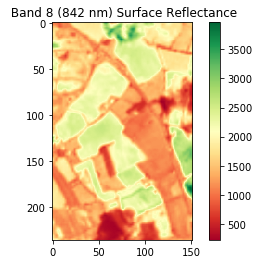

In [24]:
plt.imshow(NIR,cmap='RdYlGn')
plt.title(' Band 8 (842 nm) Surface Reflectance')
plt.colorbar()
plt.show()

The UTM coordinates for the top left corner of each ROI are stored here:

In [25]:
farmProcessor.newRefPixUtm

[(604825, 5783875), (605105, 5782875), (604625, 5782675)]

## 2.2 Getting a mean spectrum

A crude method for getting a mean spectrum for the ROI is included, although note that this takes an average over the whole cutout rather than exactly the area specified by the ROI coordinates

In [26]:
spectra = farmProcessor.as_mean_spectrum()

Lets plot these in matplotlib:

In [27]:
#labels = 
plt.plot(farmProcessor.bandCentres,spectra[0],label='Whole Farm')
plt.scatter(farmProcessor.bandCentres,spectra[0])
plt.plot(farmProcessor.bandCentres,spectra[1],label='Field')
plt.scatter(farmProcessor.bandCentres,spectra[1])
plt.plot(farmProcessor.bandCentres,spectra[2],label='Housing')
plt.scatter(farmProcessor.bandCentres,spectra[2])

plt.legend()
plt.show()

## 2.3 Combining ROIs

If you want to view an area containing all of your ROIs, use the method:

In [28]:
farmProcessor.combine_ROIs()

you can then make an array (as above) of the area covering all ROIs:

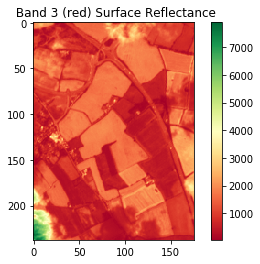

In [29]:
plt.imshow(farmProcessor.arrays[0][:,:,2],cmap='RdYlGn')
plt.title(' Band 3 (red) Surface Reflectance')
plt.colorbar()
plt.show()

(Note that once you've combined ROIs you can't uncombine them again.)

## 2.4 RGB images

There's a quick function for RGB images:

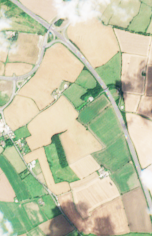

In [30]:
farmImages = sp.batchProcessor(gran,[farm])
farmImages.as_RGB_images()[0]

this can be masked with 0 values:

In [31]:
farmImages.as_RGB_images(mask=True)[0]

## 2.5 Array Masking

The NP arrays can also be converted to masked arrays with the mask=True command.

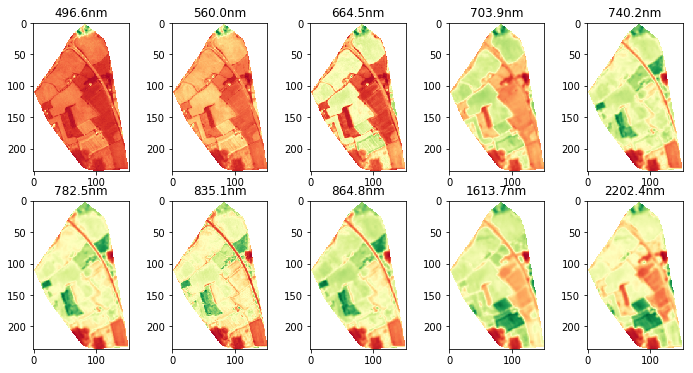

In [32]:
# reprocess the arrays to convert to numpy.ma.array format
farmImages.make_arrays(mask=True)

# and plot
fig = plt.figure(figsize = (12,6))

for i in range(10):
    a = fig.add_subplot(2,5,i+1)
    plt.imshow(farmImages.as_NP_arrays()[0][:,:,i],cmap='RdYlGn')
    a.set_title(str(farmImages.bandCentres[i])+'nm')
plt.show()

# Current Development

Wishlist:
- implement cloud masking for individual pixel exclusion
- add sentinelOne capability